In [1]:
import astropy.io
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as col
import math
import pandas as pd
import time

from astropy.io import fits
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from math import pi

In [2]:
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    lobe_dist_kpc = 0.0
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        try:
            main_max = []
            main_min = []
            for point in max_lst:
                if point > x_vals_med and point < x_vals_Q3:
                    main_max.append(point)
            for point in min_lst:
                if point > x_vals_Q1 and point < x_vals_med:
                    main_min.append(point)

            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(max(main_min), min(main_max)):
                slice_vals_edit[i] = float(0)

            lobe_dist = min(main_max) - max(main_min)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True


            #Determines and prints length of jet in pixels. Estimates to 0.98
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)

            lobe_dist_cm = lobe_dist * pixel_size
            lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)
            
        except ValueError:
            p = 0

    return jet_size_kpc

In [3]:
def luminosity_determiner(data, pixel_area):
    I_sum = 0
    for row in data:
        for element in row:
            I_sum += element
    
    luminosity = ((I_sum * pixel_area) * 1e-23) * (4 * pi * 4.25e10) 
    luminosity = '{:0.4e}'.format(luminosity)
    luminosity = float(luminosity)
    
    return luminosity

In [4]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

In [5]:
#Main Calling Block of Code

print("\nLUMINOSITY DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

years = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 121.2, 256.1, 513.1, 773.1]
jet_dim_data = np.array([["Jet Strength (L)", "Sim Time (Myr)", "Jet Length (kpc)", "Luminosity (ergs/s/Hz)"]])


path = '**/Group*_rc30_*nu=30.0*0.00_1.00_0.00*Myr.fits*'

# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    file_count = 0
    progress(file_count, total_files)

    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1
                                             
        try:
            fits_image_hdul = fits.open(file)

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            sim_time = round(float(sim_time[:-4]), 1)

            pixel = fits_image_hdul[0].header['CDELT1']
            pixel_size = float(pixel[:-3])

            #Difines Data From FITS image and records image dimensions
            data =  fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            #print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

            L = sim_title.find("L")
            jet_stren = sim_title[L+1:L+4] 


            jet_len = jet_length(data, pixel_size)

            pixel_area = pixel_size**2
            luminosity = luminosity_determiner(data, pixel_area)

            #print("Jet Length: {} kpc".format(jet_len))
            #print("Luminosity: {} ergs/s/Hz".format(luminosity))

            file_data = np.array([jet_stren, float(sim_time), jet_len, luminosity])
            jet_dim_data = np.vstack([jet_dim_data, file_data])

            #print("{}\n".format("_"*100))
            
            progress(file_count, total_files)

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")



else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))
        
data_table = pd.DataFrame(jet_dim_data)
        
print(data_table)
with open("LUM_LEN_30.npy", "wb") as open_file:
        np.save(open_file, jet_dim_data)


LUMINOSITY DETERMINING PROGRAM:
____________________________________________________________________________________________________

                   0               1                 2                       3
0   Jet Strength (L)  Sim Time (Myr)  Jet Length (kpc)  Luminosity (ergs/s/Hz)
1                430             1.0            7.7454              2.2161e+32
2                430             2.0           11.3084              2.3219e+32
3                430             4.0           15.5837              2.9579e+32
4                430             8.0           21.8074              3.1218e+32
5                430            16.0           30.1664              3.2218e+32
6                430            32.0           41.9629              3.1965e+32
7                430            64.0           59.9844              2.0844e+32
8                430           127.6           98.4549              5.7762e+31
9                430           237.6          145.2808              1.9044e

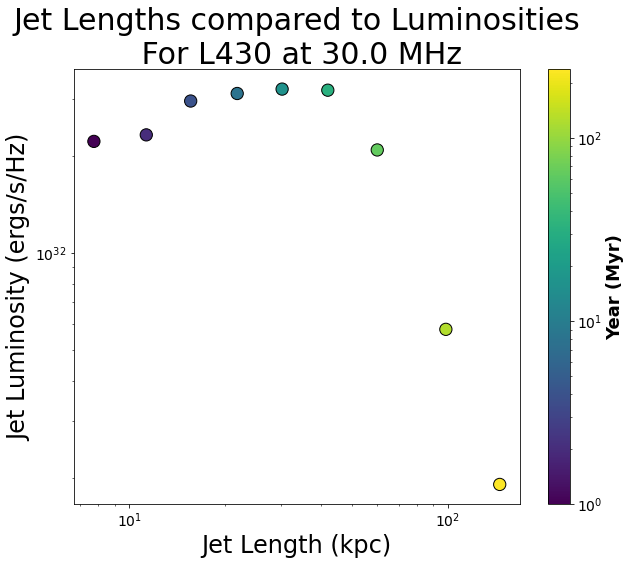

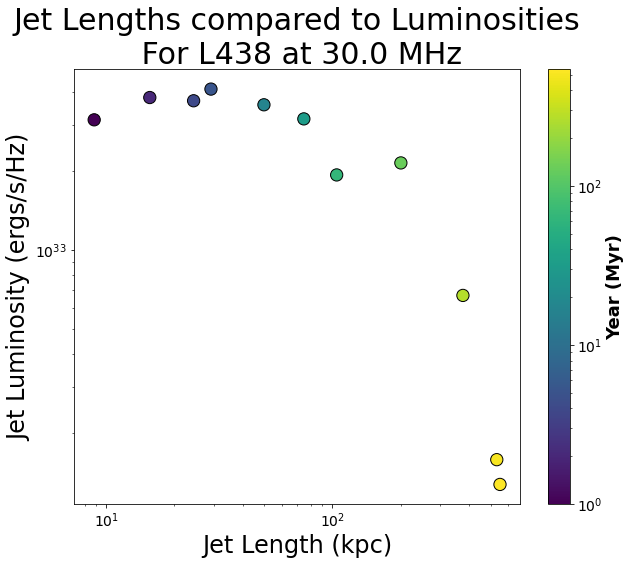

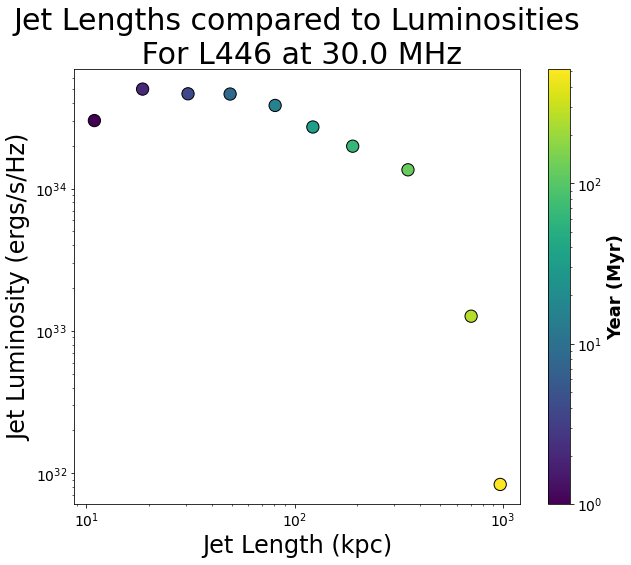

In [6]:
plt.rcParams["figure.figsize"] = (10,8)

with open("LUM_LEN_30.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    sim_time = []
    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, c=sim_time, norm=col.LogNorm(), s=150, edgecolors = 'k')
            cb = plt.colorbar()
            cb.set_label(label = "Year (Myr)", weight='bold', fontsize=18)
            cb.ax.tick_params(labelsize=14)
            
            plt.loglog()
            plt.xlabel("Jet Length (kpc)", fontsize=24)
            plt.xticks(fontsize=14)
            plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
            plt.yticks(fontsize=14)
            plt.title("Jet Lengths compared to Luminosities\n For L{} at 30.0 MHz".format(prev_jet_stren), fontsize=30)
            #plt.legend(loc=2, prop={'size': 8})
            plt.show()
            
            sim_time = []
            jet_len_val = []
            lum_val = []
            
        sim_time.append(float(lum_len_data[i, 1]))
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        #color_index = pos_year.index(sim_time)
        #colors = pos_colors[color_index]

        
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, c=sim_time, norm=col.LogNorm(), s=150, edgecolors = 'k')
cb = plt.colorbar()
cb.set_label(label = "Year (Myr)", weight='bold', fontsize=18)
cb.ax.tick_params(labelsize=14)

plt.loglog()
plt.xlabel("Jet Length (kpc)", fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
plt.yticks(fontsize=14)
plt.title("Jet Lengths compared to Luminosities\n For L{} at 30.0 MHz".format(jet_stren), fontsize=30)
#plt.legend(loc=2, prop={'size': 8})
plt.show()
#plt.savefig('Jet_Lengths_vs_Time.png')

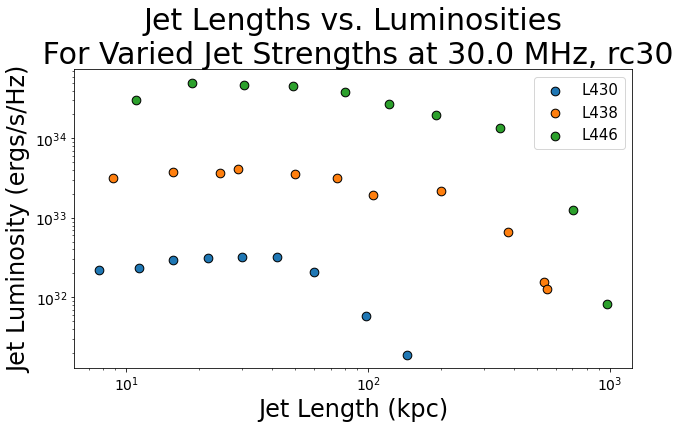

In [7]:
plt.rcParams["figure.figsize"] = (10,5.5)

with open("LUM_LEN_30.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, label = "L{}".format(prev_jet_stren), s=75, edgecolors = 'k')
            
            jet_len_val = []
            lum_val = []
            
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, label = "L{}".format(prev_jet_stren), s=75, edgecolors = 'k')
plt.loglog()
plt.xlabel("Jet Length (kpc)", fontsize=24)
plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Jet Lengths vs. Luminosities\n For Varied Jet Strengths at 30.0 MHz, rc30", fontsize=30)
plt.legend(prop={'size': 15})
plt.show()
#plt.savefig('Jet_Lengths_vs_Time.png')

In [8]:
#Main Calling Block of Code

print("\nLUMINOSITY DETERMINING PROGRAM:")
print("{}\n".format("_"*100))

years = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 121.2, 256.1, 513.1, 773.1]
jet_dim_data = np.array([["Jet Strength (L)", "Sim Time (Myr)", "Jet Length (kpc)", "Luminosity (ergs/s/Hz)"]])


path = '**/Group*_rc30_*nu=1400.0*0.00_1.00_0.00*Myr.fits*'

# Determines if there are any files in device
total_files = len(glob.glob(path, recursive=True))

if total_files > 0:
    file_count = 0
    progress(file_count, total_files)

    for file in sorted(glob.glob(path, recursive=True)):

        file_count += 1
                                             
        try:
            fits_image_hdul = fits.open(file)

            #Displays FITS Image title, time index, and pixel size
            sim_title = fits_image_hdul[0].header['OBJECT']
            sim_time = fits_image_hdul[0].header['TIME']
            sim_time = round(float(sim_time[:-4]), 1)

            pixel = fits_image_hdul[0].header['CDELT1']
            pixel_size = float(pixel[:-3])

            #Difines Data From FITS image and records image dimensions
            data =  fits_image_hdul[0].data
            length = len(data[0])
            width = len(data)
            #print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

            L = sim_title.find("L")
            jet_stren = sim_title[L+1:L+4] 


            jet_len = jet_length(data, pixel_size)

            pixel_area = pixel_size**2
            luminosity = luminosity_determiner(data, pixel_area)

            #print("Jet Length: {} kpc".format(jet_len))
            #print("Luminosity: {} ergs/s/Hz".format(luminosity))

            file_data = np.array([jet_stren, float(sim_time), jet_len, luminosity])
            jet_dim_data = np.vstack([jet_dim_data, file_data])

            #print("{}\n".format("_"*100))
            
            progress(file_count, total_files)

        except OSError:
            print("Error with file: {}".format(file))
            print("Empty or corrupt FITS file")



else:
    print("ERROR: Could not find any necessary files on your device")
    print("Program intakes files of the name: {}".format(path))
        
data_table = pd.DataFrame(jet_dim_data)
        
print(data_table)
with open("LUM_LEN_1400.npy", "wb") as open_file:
        np.save(open_file, jet_dim_data)


LUMINOSITY DETERMINING PROGRAM:
____________________________________________________________________________________________________

                   0               1                 2                       3
0   Jet Strength (L)  Sim Time (Myr)  Jet Length (kpc)  Luminosity (ergs/s/Hz)
1                430             1.0            7.8105              3.1106e+31
2                430             2.0           11.3084              3.2005e+31
3                430             4.0           15.6487              4.0918e+31
4                430             8.0           21.8723              4.3031e+31
5                430            16.0           30.2961              4.3806e+31
6                430            32.0           42.1575              4.0567e+31
7                430            64.0           59.5305              2.3379e+31
8                430           127.6           97.9364              3.1686e+30
9                430           237.6          143.5952              2.5967e

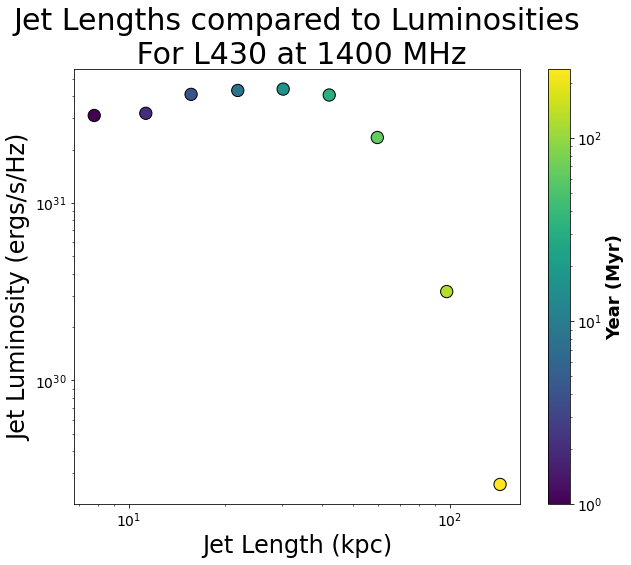

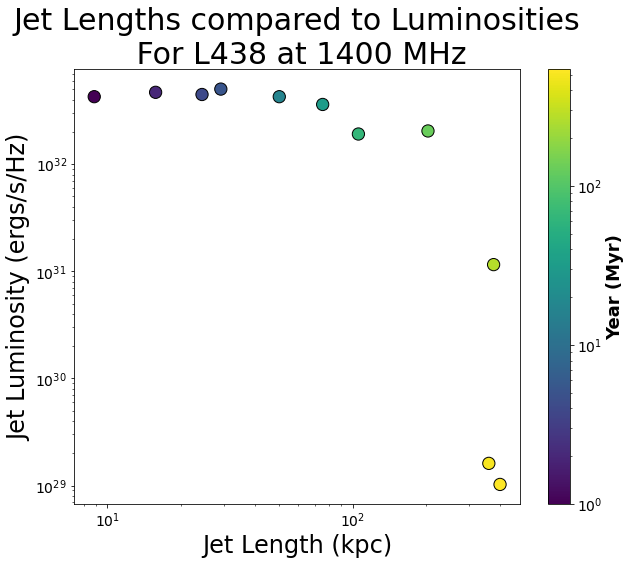

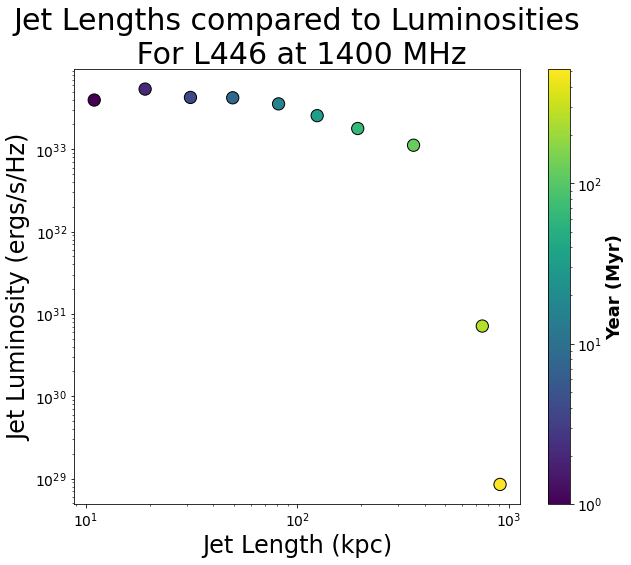

In [9]:
plt.rcParams["figure.figsize"] = (10,8)

with open("LUM_LEN_1400.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    sim_time = []
    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, c=sim_time, norm=col.LogNorm(), s=150, edgecolors = 'k')
            cb = plt.colorbar()
            cb.set_label(label = "Year (Myr)", weight='bold', fontsize=18)
            cb.ax.tick_params(labelsize=14)
            
            plt.loglog()
            plt.xlabel("Jet Length (kpc)", fontsize=24)
            plt.xticks(fontsize=14)
            plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
            plt.yticks(fontsize=14)
            plt.title("Jet Lengths compared to Luminosities\n For L{} at 1400 MHz".format(prev_jet_stren), fontsize=30)
            #plt.legend(loc=2, prop={'size': 8})
            plt.show()
            
            sim_time = []
            jet_len_val = []
            lum_val = []
            
        sim_time.append(float(lum_len_data[i, 1]))
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        #color_index = pos_year.index(sim_time)
        #colors = pos_colors[color_index]

        
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, c=sim_time, norm=col.LogNorm(), s=150, edgecolors = 'k')
cb = plt.colorbar()
cb.set_label(label = "Year (Myr)", weight='bold', fontsize=18)
cb.ax.tick_params(labelsize=14)

plt.loglog()
plt.xlabel("Jet Length (kpc)", fontsize=24)
plt.xticks(fontsize=14)
plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
plt.yticks(fontsize=14)
plt.title("Jet Lengths compared to Luminosities\n For L{} at 1400 MHz".format(jet_stren), fontsize=30)
#plt.legend(loc=2, prop={'size': 8})
plt.show()
#plt.savefig('Jet_Lengths_vs_Time.png')

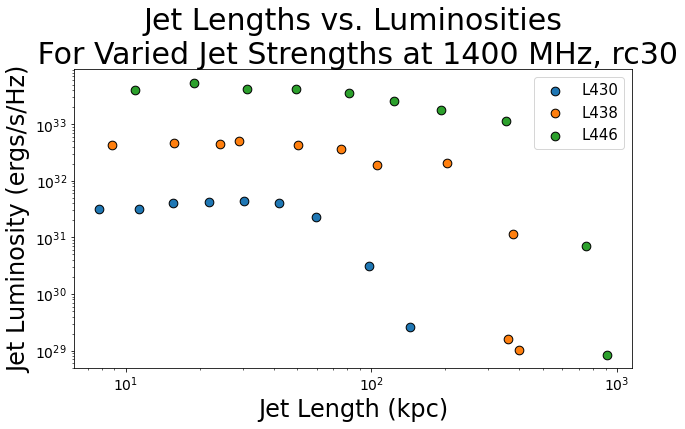

In [10]:
plt.rcParams["figure.figsize"] = (10,5.5)

with open("LUM_LEN_1400.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, label = "L{}".format(prev_jet_stren), s=75, edgecolors = 'k')
            
            jet_len_val = []
            lum_val = []
            
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, label = "L{}".format(prev_jet_stren), s=75, edgecolors = 'k')
plt.loglog()
plt.xlabel("Jet Length (kpc)", fontsize=24)
plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Jet Lengths vs. Luminosities\n For Varied Jet Strengths at 1400 MHz, rc30", fontsize=30)
plt.legend(prop={'size': 15})
plt.show()
#plt.savefig('Jet_Lengths_vs_Time.png')

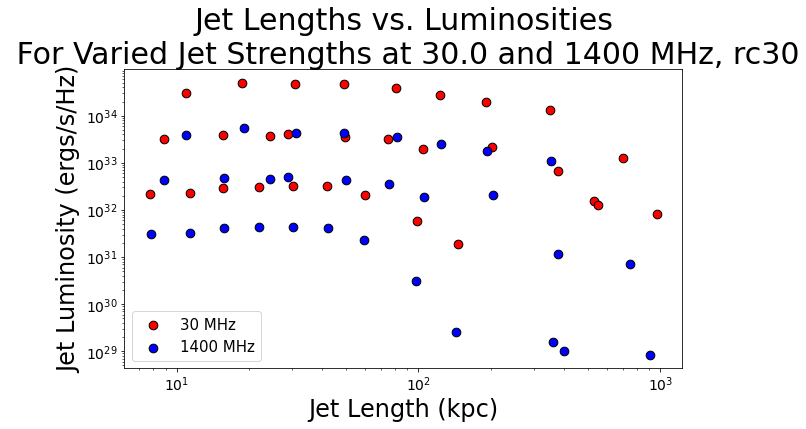

In [14]:
plt.rcParams["figure.figsize"] = (10,5.5)

with open("LUM_LEN_30.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, color = "red", s=75, edgecolors = 'k')
            
            jet_len_val = []
            lum_val = []
            
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, label = "30 MHz", color = "red", s=75, edgecolors = 'k')


with open("LUM_LEN_1400.npy", "rb") as open_file:
    lum_len_data = np.load(open_file)
    prev_jet_stren = lum_len_data[1, 0]

    jet_len_val = []
    lum_val = []
    
    for i in range(1, total_files):

        jet_stren = lum_len_data[i, 0]
        
 
        if jet_stren != prev_jet_stren:
            plt.scatter(jet_len_val, lum_val, color = "blue", s=75, edgecolors = 'k')
            
            jet_len_val = []
            lum_val = []
            
        jet_len_val.append(float(lum_len_data[i, 2]))
        lum_val.append(float(lum_len_data[i, 3]))
        
        
        prev_jet_stren = jet_stren


plt.scatter(jet_len_val, lum_val, label = "1400 MHz", color = "blue", s=75, edgecolors = 'k')



plt.loglog()
plt.xlabel("Jet Length (kpc)", fontsize=24)
plt.ylabel("Jet Luminosity (ergs/s/Hz)", fontsize=24)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Jet Lengths vs. Luminosities\n For Varied Jet Strengths at 30.0 and 1400 MHz, rc30", fontsize=30)
plt.legend(prop={'size': 15})
plt.show()